In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pysyncon import Dataprep, Synth, AugSynth
import itertools
import numpy as np
import timeit

In [3]:
# All states:
states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]
# States belonging to RGGI. Exclude VA here; it was only in RGGI for a short time
# Connecticut, Delaware, Maine, Maryland, Massachusetts, New Hampshire, New Jersey, New York, Pennsylvania, Rhode Island, and Vermont 
rggi_states = ["CT", "DE", "ME", "MD", "MA", "NH", "NJ", "NY", "PA", "RI", "VT"]
# States with cap-and-trade programs as well as AK and HI, which are of course outside the continental US.
other_states = ["CA", "AK", "HI"]
# States not belonging to RGGI or other cap-and-trade programs.
# WA will be included here because its cap-and-trade program was not around until after 2020.
control_states = list(set(states) - set(rggi_states) - set(other_states))

# Verify all fifty states accounted for:
assert(len(rggi_states) + len(control_states) + len(other_states) == 50)

In [4]:
# Read in the dataframe
df = pd.read_csv(os.path.join("..", "..", "..", "SharedData", "total_state_data.csv"))
df.date = pd.to_datetime(df.date)
df = df[(df.date.dt.year>=1990)&(df.date.dt.year<2020)]

In [5]:
# Do some per capita calculations:
df['co2_per_capita']   = df['monthly_emissions']   / df['monthly_population']
df['gdp_per_capita']   = df['gdp_rel_2017_interp'] / df['monthly_population']
df['eprod_per_capita'] = df['monthly_energy_prod'] / df['monthly_population']
df['eflow_per_capita'] = df['monthly_energy_flow'] / df['monthly_population']

In [6]:
df_1 = pd.DataFrame(data=[[[1,2],3]], columns=["Features", "AvgLossSyn"],dtype='object')
df_1.to_csv("test.csv", columns=["Features", "AvgLossSyn"])
df_2 = pd.DataFrame(data=[[[4,5],6]], columns=["Features", "AvgLossSyn"],dtype='object')
# df_1 = df_1.astype('object')
# df_1.loc[0, "Features"] = [1,2]
# df_1.loc[0, "AvgLossSyn"] = 3
# df_2 = pd.DataFrame({"Features":[1], "AvgLossSyn":[2]})
df_3 = pd.concat([df_1,df_2])
# df_1.to_csv("text.csv")
df_load = pd.read_csv("test.csv", index_col=0)
# df_load.loc[0,"Features"]
df_load.head()

,Features,AvgLossSyn
0,"[1, 2]",3


# 1997 - 2009 without co2 as a special dependent

c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


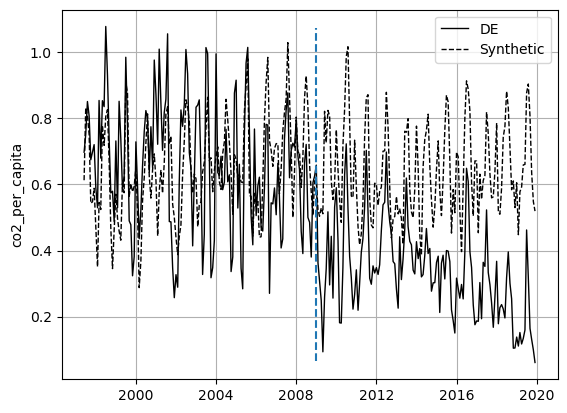

c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


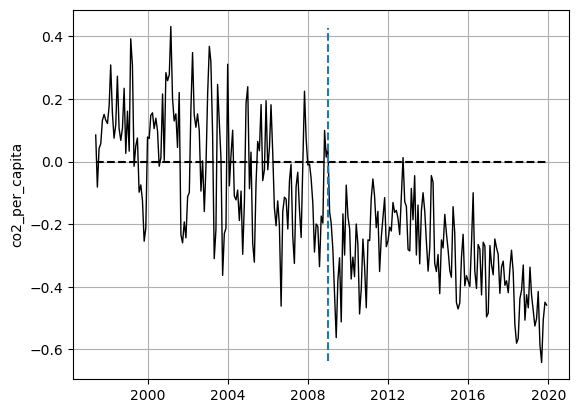

0.03487415249880225


c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


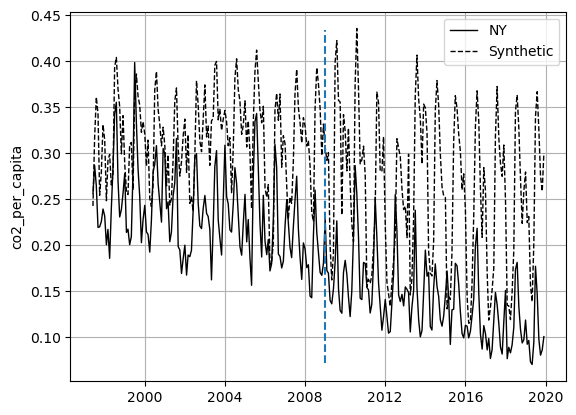

c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


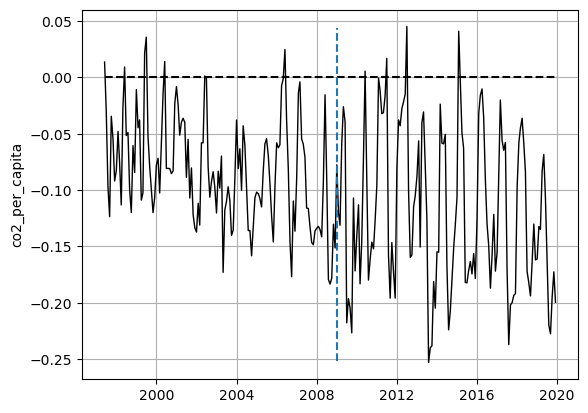

0.009038768321793563


c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


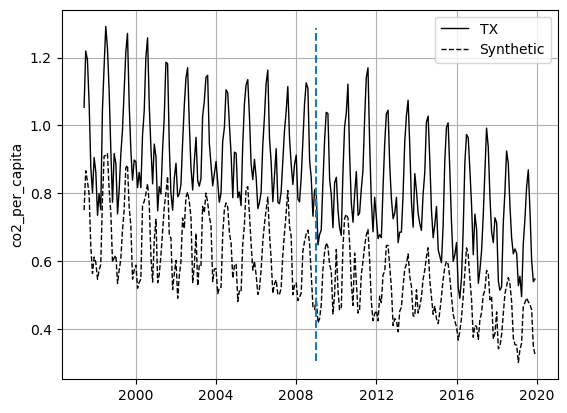

c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


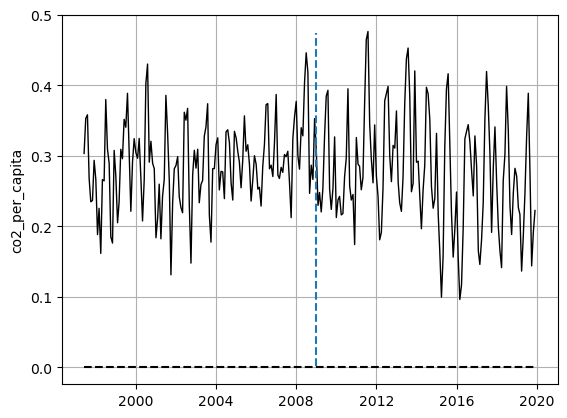

0.08599036650698215


In [9]:
monthly_features_of_interest = ['monthly_emissions', 'prcp', 'snow', 'tavg', 
        'gdp_rel_2017_interp', 'monthly_energy_prod',
       'monthly_energy_use', 
       'monthly_energy_flow', 
        'monthly_renew_pct', 'monthly_fossil_pct',
       'monthly_pop_density', 'monthly_emissions_sma']

features = ['monthly_emissions', 'gdp_rel_2017_interp', 'monthly_energy_use', 'monthly_pop_density', 'monthly_emissions_sma']

for state_id in ["DE", "NY", "TX"]:
    # state_id = rggi_state 
    control_ids = list(set(control_states) - set([state_id]))
    rggi_ids = list(set(rggi_states) - set([state_id]))

    # Stop the notebook if something goes wrong
    assert(state_id not in other_states)
    assert(len(control_ids) + len(rggi_ids) + 1 == 50 - len(other_states))

    # Do computations monthly
    month_jumps = 1

    # Set up ranges
    UL = 2009
    LL_TIME = 1997      # Time range over which to perform fit

    preintervention_time_range = df.date[(df.date.dt.year>=LL_TIME)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]

    years = pd.date_range(start='1997-06-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()[::month_jumps]
    
    
    special_predictors = [(feature, preintervention_time_range, 'mean') for feature in features]
    # special_predictors.append(("co2_per_capita", preintervention_time_range, 'mean'))
    
    
    dataprep_control = Dataprep(
        foo=df,
        predictors=[],
        predictors_op="mean",
        time_predictors_prior=preintervention_time_range,
        special_predictors=special_predictors,
        dependent="co2_per_capita",
        unit_variable="state",
        time_variable="date",
        treatment_identifier=state_id,
        controls_identifier= control_ids,
        time_optimize_ssr=preintervention_time_range
    )
    
    # Do a synthetic control fit to the data using control states
    synth = Synth()

    synth.fit(dataprep=dataprep_control)
    
    synth.path_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
    synth.gaps_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
    print(synth.loss_V)
    synth.summary()

# 1997 - 2009 WITH co2 as a special dependent

c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


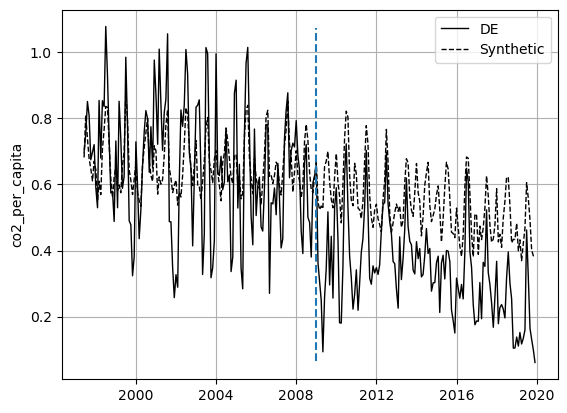

c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


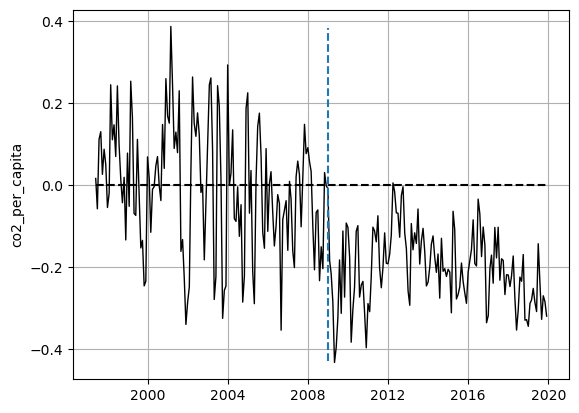

0.022867214851189088


c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


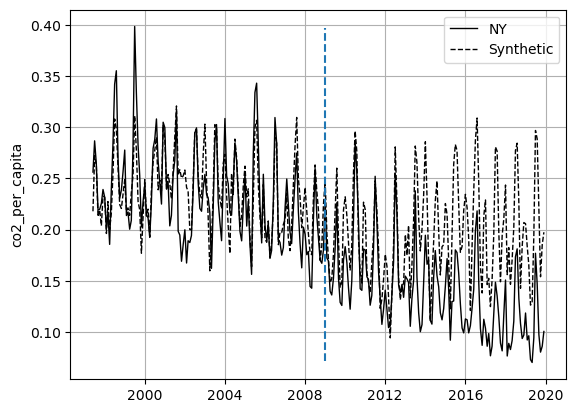

c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


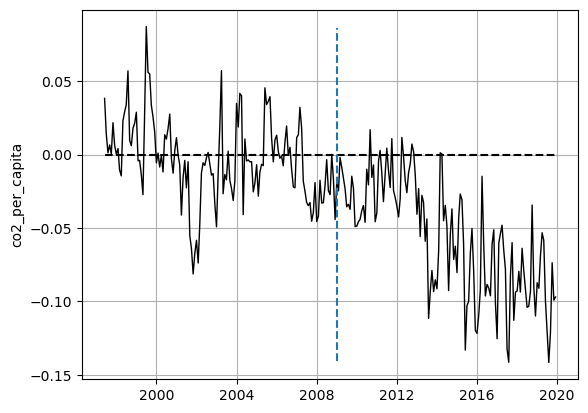

0.0007948508034124878


c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


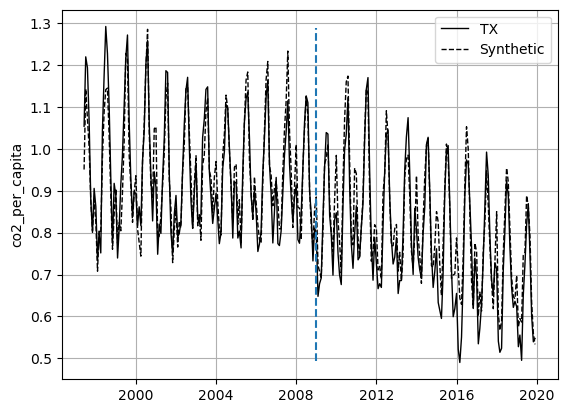

c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


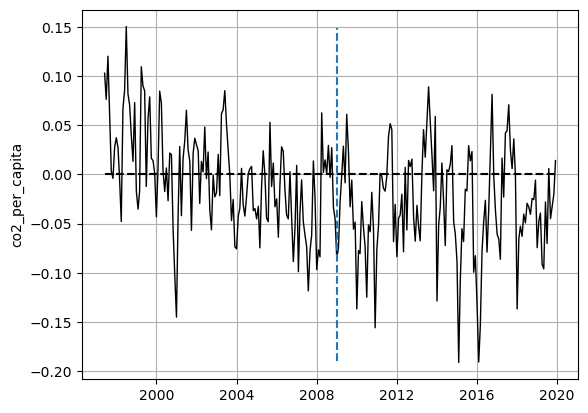

0.00274863162312301


In [ ]:
monthly_features_of_interest = ['monthly_emissions', 'prcp', 'snow', 'tavg', 
        'gdp_rel_2017_interp', 'monthly_energy_prod',
       'monthly_energy_use', 
       'monthly_energy_flow', 
        'monthly_renew_pct', 'monthly_fossil_pct',
       'monthly_pop_density', 'monthly_emissions_sma']

features = ['tavg', 'monthly_renew_pct']

for state_id in ["DE", "NY", "TX"]:
    # state_id = rggi_state 
    control_ids = list(set(control_states) - set([state_id]))
    rggi_ids = list(set(rggi_states) - set([state_id]))

    # Stop the notebook if something goes wrong
    assert(state_id not in other_states)
    assert(len(control_ids) + len(rggi_ids) + 1 == 50 - len(other_states))

    # Do computations monthly
    month_jumps = 1

    # Set up ranges
    UL = 2009
    LL_TIME = 1997      # Time range over which to perform fit

    preintervention_time_range = df.date[(df.date.dt.year>=LL_TIME)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]
    
    special_predictors = [(feature, preintervention_time_range, 'mean') for feature in features]
    special_predictors.append(("co2_per_capita", preintervention_time_range, 'mean'))
    
    
    dataprep_control = Dataprep(
        foo=df,
        predictors=[],
        predictors_op="mean",
        time_predictors_prior=preintervention_time_range,
        special_predictors=special_predictors,
        dependent="co2_per_capita",
        unit_variable="state",
        time_variable="date",
        treatment_identifier=state_id,
        controls_identifier= control_ids,
        time_optimize_ssr=preintervention_time_range
    )
    
    # Do a synthetic control fit to the data using control states
    synth = Synth()

    synth.fit(dataprep=dataprep_control)
    
    synth.path_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
    synth.gaps_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
    print(synth.loss_V)
    synth.summary()

# 1991 - 2009 WITH co2 as a special dependent

c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


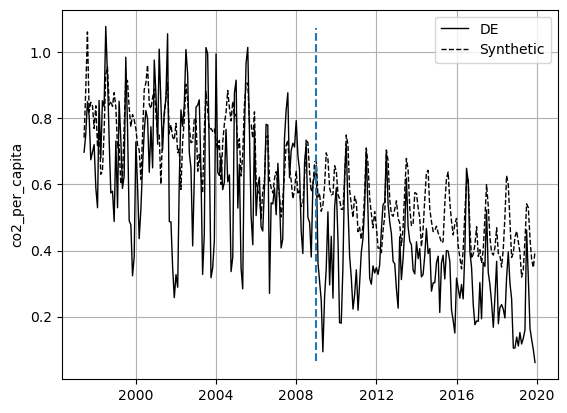

c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


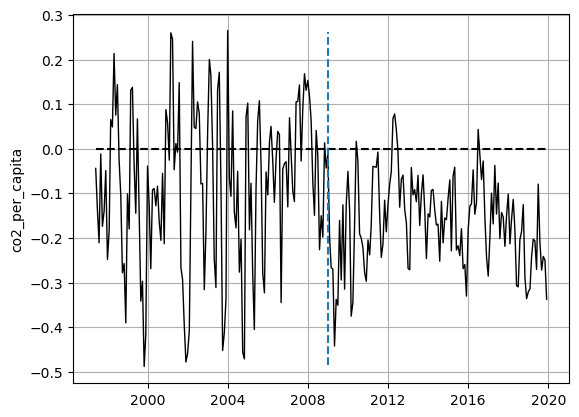

0.031145122100194548


c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


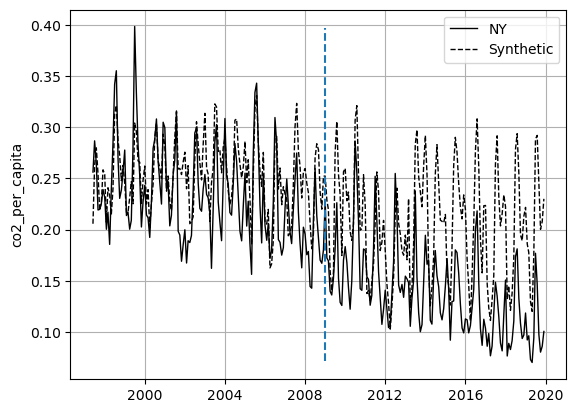

c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


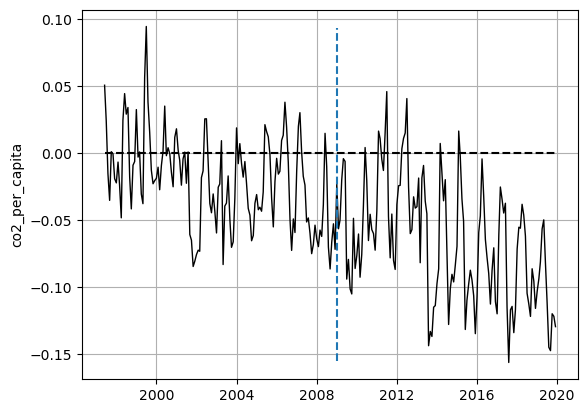

0.0017493895419400643


c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


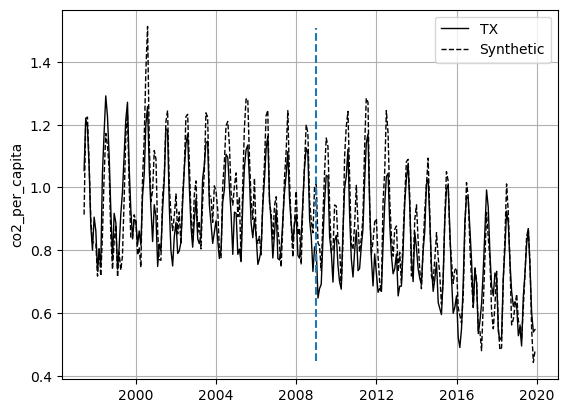

c:\Users\Bluecat\miniforge3\envs\regulators\Lib\site-packages\pysyncon\dataprep.py:302: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  Z = self.foo[self.foo[self.time_variable].isin(time_period)].pivot(


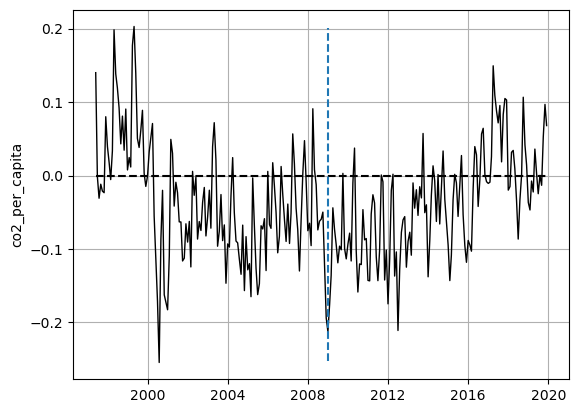

0.0061906198993291915


In [11]:
monthly_features_of_interest = ['monthly_emissions', 'prcp', 'snow', 'tavg', 
        'gdp_rel_2017_interp', 'monthly_energy_prod',
       'monthly_energy_use', 
       'monthly_energy_flow', 
        'monthly_renew_pct', 'monthly_fossil_pct',
       'monthly_pop_density', 'monthly_emissions_sma']

features = ['snow', 'tavg', 'monthly_energy_prod', 'monthly_fossil_pct']

for state_id in ["DE", "NY", "TX"]:
    # state_id = rggi_state 
    control_ids = list(set(control_states) - set([state_id]))
    rggi_ids = list(set(rggi_states) - set([state_id]))

    # Stop the notebook if something goes wrong
    assert(state_id not in other_states)
    assert(len(control_ids) + len(rggi_ids) + 1 == 50 - len(other_states))

    # Do computations monthly
    month_jumps = 1

    # Set up ranges
    UL = 2009
    LL_TIME = 1991      # Time range over which to perform fit

    preintervention_time_range = df.date[(df.date.dt.year>=LL_TIME)&(df.date.dt.year<UL)&(df.state==state_id)][::month_jumps]
    
    
    special_predictors = [(feature, preintervention_time_range, 'mean') for feature in features]
    special_predictors.append(("co2_per_capita", preintervention_time_range, 'mean'))
    
    
    dataprep_control = Dataprep(
        foo=df,
        predictors=[],
        predictors_op="mean",
        time_predictors_prior=preintervention_time_range,
        special_predictors=special_predictors,
        dependent="co2_per_capita",
        unit_variable="state",
        time_variable="date",
        treatment_identifier=state_id,
        controls_identifier= control_ids,
        time_optimize_ssr=preintervention_time_range
    )
    
    # Do a synthetic control fit to the data using control states
    synth = Synth()

    synth.fit(dataprep=dataprep_control)
    
    synth.path_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
    synth.gaps_plot(time_period=years, treatment_time=pd.to_datetime("2009-01-01"))
    print(synth.loss_V)
    synth.summary()